In [1]:
import pandas as pd
import numpy as np
import re
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import StratifiedKFold

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer, average_precision_score, precision_recall_curve

from sklearn.calibration import CalibratedClassifierCV, calibration_curve

import matplotlib.pyplot as plt
import seaborn as sns

import nlp_utils as utils
from nlp_utils import get_vectorizer

# from lime import lime_text
# import warnings
# warnings.filterwarnings("ignore", category=FutureWarning)

pd.options.display.max_colwidth = 100

# Pretty plots
%matplotlib inline
plt.style.use('seaborn-ticks')
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (7, 5)
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

# Display wide columns
pd.options.display.max_colwidth = 100

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vrozova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


___
# SH vs Controls (excl. SI)

Train on RMH dataset using only SH cases and controls. Test the final model on SI cases.

### Load data and create training and test sets

In [2]:
# Set up
text = "entities"
class_names = ("Controls", "Self-harm")
    
# Undersampling
undersample = False
n_controls = 10000

# Parameters of feature extraction
vectorizer_mode = "select features"
params = {'analyzer' : "word",
          'ngram_range' : (1,1),
          'use_idf' : True,
          'mode' : "select by pvalue",
          'thresh' : 0.001}

reduce_dim = False
lsa_method = "svd"
n_components = 100

add_length = False # no effect

In [3]:
df_train = pd.read_csv("../data/rmh_train.csv")
if undersample:
    df_train = pd.concat([df_train[df_train.SH == 0].sample(n_controls, random_state=42), 
                          df_train[df_train.SH
                                   != 0]], 
                         axis=0)

df_train.SH.value_counts()

0    307875
1      4302
Name: SH, dtype: int64

In [4]:
y_train = df_train.SH.values

### Model development

In [ ]:
vectorizer = get_vectorizer(vectorizer_mode, params)

clfs = (
    MultinomialNB(),
    LogisticRegression(solver='lbfgs', max_iter=1000, class_weight="balanced"),
#     KNeighborsClassifier(),
#     RandomForestClassifier(class_weight="balanced"),
    XGBClassifier(objective="binary:logistic"),
#     CalibratedClassifierCV(XGBClassifier(objective="binary:logistic"),
#                            method='isotonic', cv=3),
#     CalibratedClassifierCV(XGBClassifier(objective="binary:logistic", **tuned_params),
#                            method='isotonic', cv=3),
)

In [ ]:
%%time
for clf in clfs:
    pipe = make_pipeline(vectorizer, clf)
    scores = utils.benchmark_cv_score(pipe, df_train[text], y_train, class_names)

### Hyperparameter tuning

In [ ]:
n_estimators = [100, 200, 300, 400]

param_grid = {"calibratedclassifiercv__base_estimator__n_estimators": n_estimators}

vectorizer = get_vectorizer(vectorizer_mode, params)
clf = CalibratedClassifierCV(XGBClassifier(objective="binary:logistic", 
                                           use_label_encoder=False), 
                             method='isotonic', cv=3)
pipe = make_pipeline(vectorizer, clf)

utils.grid_search_cv(pipe, df_train[text], y_train, 
                     param_grid, scoring="average_precision")

In [ ]:
max_depth = [2, 4, 6, 8]
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4]
subsample = [0.3, 0.5, 0.8, 1.0]
scale_pos_weight = [1, 10, 50, 100]

param_grid = {"calibratedclassifiercv__base_estimator__max_depth": max_depth, 
              "calibratedclassifiercv__base_estimator__learning_rate": learning_rate, 
              "calibratedclassifiercv__base_estimator__subsample": subsample, 
              "calibratedclassifiercv__base_estimator__scale_pos_weight": scale_pos_weight
             }

vectorizer = get_vectorizer(vectorizer_mode, params)
clf = CalibratedClassifierCV(XGBClassifier(objective="binary:logistic", 
                                           n_estimators=300, 
                                           use_label_encoder=False), 
                             method='isotonic', cv=3)
pipe = make_pipeline(vectorizer, clf)

utils.random_search_cv(pipe, df_train[text], y_train, 
                       param_grid, scoring="average_precision")

In [5]:
# Calibrated XGB on entities:
tuned_params = {'n_estimators': 300,
                'subsample': 1.0, 
                'scale_pos_weight': 1, 
                'max_depth': 6, 
                'learning_rate': 0.2}
# Calibrated XGB on negated entities:
# tuned_params = {'n_estimators': 300,
#                 'subsample': 1.0, 
#                 'scale_pos_weight': 1, 
#                 'max_depth': 8, 
#                 'learning_rate': 0.3}
# Calibrated XGB on linked entities:
# tuned_params = {'n_estimators': 200, 
#                 'subsample': 0.8, 
#                 'scale_pos_weight': 1, 
#                 'max_depth': 8, 
#                 'learning_rate': 0.2}
# Calibrated XGB on negated linked entities:
# tuned_params = {'n_estimators': 300, 
#                 'subsample': 1.0, 
#                 'scale_pos_weight': 1, 
#                 'max_depth': 6, 
#                 'learning_rate': 0.2}

### Calibration

In [6]:
vectorizer = get_vectorizer(vectorizer_mode, params)

clf = XGBClassifier(objective="binary:logistic",use_label_encoder=False)
calibrated_clf = CalibratedClassifierCV(XGBClassifier(objective="binary:logistic", use_label_encoder=False),
                                        method='isotonic', cv=3)

pipe = make_pipeline(vectorizer, clf)
calibrated_pipe = make_pipeline(vectorizer, calibrated_clf)

**Run cross validation to calibrate the model and select threshold**

In [ ]:
y_proba = utils.benchmark_cv(pipe, df_train[text], y_train, class_names)

In [ ]:
y_proba_c = utils.benchmark_cv(calibrated_pipe, df_train[text], y_train, class_names)

**Calibration plot**

In [ ]:
sns.lineplot(x=[0, 1], y=[0, 1], color=sns.color_palette()[0], lw=2, linestyle='--', label="Perfectly calibrated")

fop, mpv = calibration_curve(y_train, y_proba[:,1], n_bins=30, normalize=False)
sns.lineplot(x=mpv, y=fop, 
             lw=3, marker='.', markersize=15, 
             color=sns.color_palette()[1],
             label="Uncalibrated");

fop, mpv = calibration_curve(y_train, y_proba_c[:,1], n_bins=30, normalize=False)
sns.lineplot(x=mpv, y=fop, 
             lw=3, marker='.', markersize=15, 
             color=sns.color_palette()[2],
             label="Calibrated");

plt.legend(fontsize=16, loc="upper left");
plt.xlabel("Mean predicted value");
plt.ylabel("Fraction of positives");

plt.savefig("./results/xgboost_calibration.png", bbox_inches='tight', dpi=300, pad_inches=0);

In [ ]:
sns.histplot(y_proba[:,1], bins=10, stat="count", 
             color=sns.color_palette()[1], lw=3, fill=False, 
             label="Uncalibrated");
sns.histplot(y_proba_c[:,1], bins=10, stat="count", 
             color=sns.color_palette()[2], lw=3, fill=False, 
             label="Calibrated");
plt.ylim([0, 2600]);
plt.legend(fontsize=16, loc="upper right");
plt.xlabel("Mean predicted value");

plt.savefig("./results/xgboost_probabilities.png", bbox_inches='tight', dpi=300, pad_inches=0);

### Threshold selection

In [ ]:
def select_threshold(y_train, y_proba):
    precision, recall, thresholds = precision_recall_curve(y_train, y_proba[:,1])
    fscore = (2 * precision * recall) / (precision + recall)
    idx = np.argmax(fscore)
    thresh = thresholds[idx]
    print('Best threshold is %.3f, F1 score=%.3f' % (thresh, fscore[idx]))
    return thresh

In [ ]:
vectorizer = get_vectorizer(vectorizer_mode, params)
clf = CalibratedClassifierCV(XGBClassifier(objective="binary:logistic", 
                                           use_label_encoder=False, 
                                           **tuned_params), 
                                        method='isotonic', cv=3)
pipe = make_pipeline(vectorizer, clf)
y_proba = utils.benchmark_cv(pipe, df_train[text], y_train, class_names)

In [ ]:
thresh = select_threshold(y_train, y_proba)

### Evaluation of the final model

In [7]:
thresh = 0.322
vectorizer = get_vectorizer(vectorizer_mode, params)
clf = CalibratedClassifierCV(XGBClassifier(objective="binary:logistic", 
                                           use_label_encoder=False, 
                                           **tuned_params), 
                                        method='isotonic', cv=3)
pipe = make_pipeline(vectorizer, clf)

**Test set**

In [8]:
pipe.fit(df_train[text], y_train)

Extracting features by a chi-squared test with p-value < 0.00...
Selected features: 970

[16:15:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:17:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:18:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('featureselector',
                 <nlp_utils.FeatureSelector object at 0x7fef8ab75f28>),
                ('calibratedclassifiercv',
                 CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=None,
                                                                     booster=None,
                                                                     colsample_bylevel=None,
                                                                     colsample_bynode=None,
                                                                     colsample_bytree=None,
                                                                     enable_categorical=False,
                                                                     gamma=None,
                                                                     gpu_id=None,
                                                                     importance_type=None,
                                                      

In [26]:
import joblib

filename = '../models/self-harm-nlp-classifier-final-xgboost.sav'
joblib.dump(pipe[1], filename)

['../models/self-harm-nlp-classifier-final-xgboost.sav']

In [5]:
import joblib

filename = '../models/self-harm-nlp-classifier-final-pipe.sav'

pipe = joblib.load(filename)
pipe

Pipeline(steps=[('featureselector',
                 <nlp_utils.FeatureSelector object at 0x7fe7b06e67b8>),
                ('calibratedclassifiercv',
                 CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=None,
                                                                     booster=None,
                                                                     colsample_bylevel=None,
                                                                     colsample_bynode=None,
                                                                     colsample_bytree=None,
                                                                     gamma=None,
                                                                     gpu_id=None,
                                                                     importance_type='gain',
                                                                     interaction_constraints=None,
                                                

In [9]:
df_test = pd.read_csv("../data/epic2020_prepared_ents.csv")
df_test.shape

(57681, 5)

In [11]:
y_proba = pipe.predict_proba(df_test[text])

In [21]:
thresh = 0.322
df_test['y_pred'] = np.where(y_proba[:,-1] > thresh, 1, 0)

In [23]:
df_test.y_pred.value_counts() / df_test.shape[0] * 100

0    98.656403
1     1.343597
Name: y_pred, dtype: float64

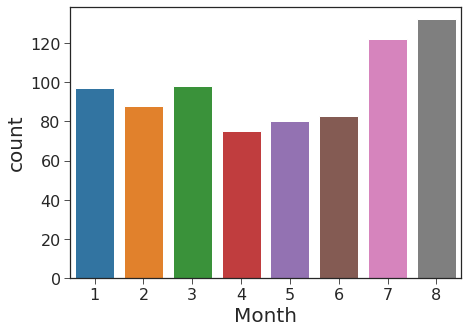

In [24]:
df_test.timestamp = pd.to_datetime(df_test.timestamp)
sns.countplot(x=df_test[df_test.y_pred==1].timestamp.dt.month);
plt.xlabel("Month");

In [10]:
y_test = df_test.SH.values
df_test.SH.value_counts()

AttributeError: 'DataFrame' object has no attribute 'SH'

In [8]:
df_test.year.value_counts()

2017    14637
2016    14099
2014    12797
2015    12761
2013    11977
2012    11774
Name: year, dtype: int64

Model evaluation on the test set

Classification report:
              precision    recall  f1-score   support

           0      0.997     0.997     0.997     76969
           1      0.800     0.800     0.800      1076

    accuracy                          0.994     78045
   macro avg      0.899     0.899     0.899     78045
weighted avg      0.994     0.994     0.994     78045

binary F2: 0.800
Average precision score: 0.866


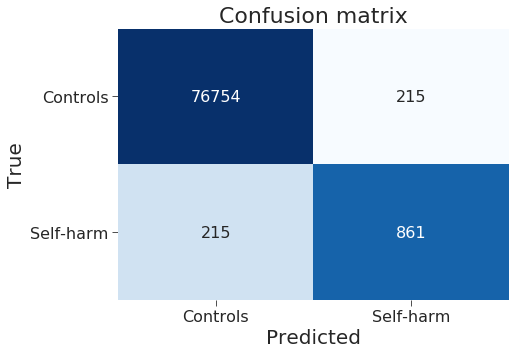

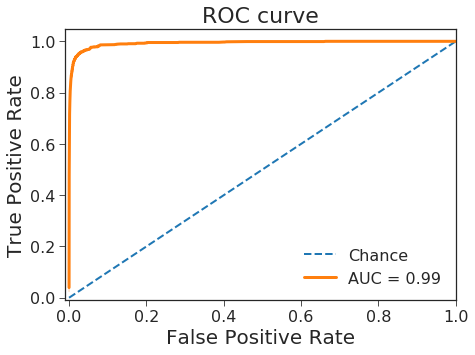

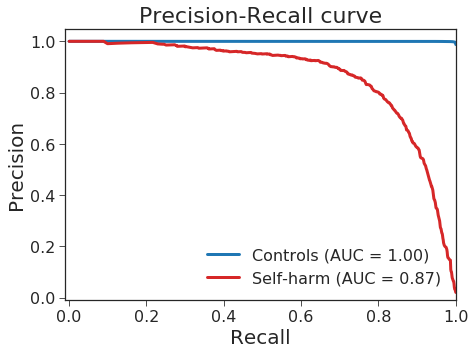

In [10]:
thresh = 0.322
y_proba = pipe.predict_proba(df_test[text])
y_pred = utils.evaluate_model(y_test, y_proba, class_names, "test", thresh=thresh, digits=3, 
                              save_figures=False, filename="./results/final_model")

In [ ]:
from sklearn.metrics import confusion_matrix

plt.rcParams['figure.figsize'] = (15, 3)

sns.heatmap(confusion_matrix(y_test, y_pred, normalize="true"), 
            annot=confusion_matrix(y_test, y_pred),
            annot_kws={'fontsize' : 18}, fmt="d",
            cmap="Blues", cbar=False, 
            xticklabels=class_names, yticklabels=class_names)

plt.yticks(rotation=0)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix");

# plt.savefig("./results/final_model_CM.png", bbox_inches='tight', dpi=300, transparent=True, pad_inches=0);

In [ ]:
print(y_pred.sum() / df_test.shape[0] * 100)
print(y_test.sum() / df_test.shape[0] * 100)

### Holdout data

In [ ]:
df_ho = pd.read_csv("../data/rmh_holdout.csv")
df_ho.shape

In [ ]:
y_ho = df_ho.SH.values
df_ho.SH.value_counts()

In [ ]:
df_ho.SI.value_counts()

In [ ]:
y_proba_ho = pipe.predict_proba(df_ho[text])
y_pred = utils.evaluate_model(y_ho, y_proba_ho, class_names, "hold-out", thresh=thresh, digits=3, 
                              save_figures=False, filename="./results/final_model_holdout")

In [ ]:
df_ho["y_pred"] = y_pred

df_ho[df_ho.y_pred == 1].SI.sum()

In [ ]:
116/301*100

In [ ]:
df_ho[(df_ho.SI==1) & (df_ho.y_pred==1)].shape[0] / df_ho.SI.sum() * 100

In [ ]:
plt.rcParams['figure.figsize'] = (7, 5)

sns.histplot(y_proba[:,1], bins=10, stat="count", 
             color=sns.color_palette()[1], lw=3, fill=False, 
             label="Test set");
sns.histplot(y_proba_ho[:,1], bins=10, stat="count", 
             color=sns.color_palette()[2], lw=3, fill=False, 
             label="Holdout set");
plt.ylim([0, 2600]);
plt.legend(fontsize=16, loc="upper right");
plt.xlabel("Mean predicted value");

# plt.savefig("./results/final_model_probabilities_holdout.png", bbox_inches='tight', dpi=300, pad_inches=0);

In [ ]:
# False-negatives that are SH: no. 0, 5 ; no. 2 should've been Control, same with 100?
ind = df_ho[(df_ho.y_pred == 0) & (df_ho.SH == 1) & (df_ho.SI == 0)].index
ind.shape

# # False-positives that are SI: no. 0,4
# ind = df_ho[(df_ho.y_pred == 1) & (df_ho.SH == 0) & (df_ho.SI == 1)].index
# ind.shape

# False-positives that are Controls: no.7
# ind = df_ho[(df_ho.y_pred == 1) & (df_ho.SH == 0) & (df_ho.SI == 0)].index
# ind.shape

In [ ]:
txt_instance = df_ho.loc[ind[5], "entities"]

print("Original text: \"%s\""% df_ho.loc[ind[5], "text"])

explainer = lime_text.LimeTextExplainer(class_names=class_names)
explained = explainer.explain_instance(txt_instance, pipe.predict_proba, num_features=5)
explained.show_in_notebook(text=txt_instance)
explained.save_to_file('lime_report5.html')

In [ ]:
explained.local_exp

In [ ]:
print("%.2f" % explained.local_exp[1][0][1])
print("%.2f" % explained.local_exp[1][1][1])
print("%.2f" % explained.local_exp[1][2][1])
print("%.2f" % explained.local_exp[1][3][1])
print("%.3f" % explained.local_exp[1][4][1])

In [ ]:
print("%.1e" % explained.local_exp[1][0][1])
print("%.1e" % explained.local_exp[1][1][1])
print("%.1e" % explained.local_exp[1][2][1])
print("%.1e" % explained.local_exp[1][3][1])
print("%.1e" % explained.local_exp[1][4][1])

In [ ]:
y_proba_ho[ind[0]]

In [ ]:
explained.as_pyplot_figure()

### Suicidal ideation

In [ ]:
df_si = pd.read_csv("./data/rmh_SI.csv")
print(df_si.shape)
df_si.head()

In [ ]:
y_proba_si = calibrated_pipe.predict_proba(df_si[text])
df_si['y_pred'] = np.where(y_proba_si[:,1] > thresh_c, 1, 0)
df_si.y_pred.sum(), df_si.y_pred.sum() / df_si.shape[0] * 100

In [ ]:
df_si[df_si.y_pred == 1].index

In [ ]:
txt_instance = df_si.loc[15, "entities"]

print("Original text: \"%s\""% df_si.loc[15, "text"])

explainer = lime_text.LimeTextExplainer(class_names=class_names)
explained = explainer.explain_instance(txt_instance, calibrated_pipe.predict_proba, num_features=5)
explained.show_in_notebook(text=txt_instance)